*This notebook was written by Zachariah Irwin (zachariah.irwin@colorado.edu) of University of Colorado Boulder on October 10, 2022 and last edited on October 11, 2022; please contact for questions on this Python code.*

# Introduction
The code below demonstrates a 3-D uniaxial strain problem using simple displacement or traction boundary conditions. The location matrix, or element connectivity matrix, is hard-coded for two trilinear hexahedral finite elements (FE), and the application of boundary conditions is similarly inflexible.

## A primer on `np.einsum`
This code makes heavy use of NumPy's `einsum` function. The advantage to using this function is (i) readability (we can use index notation from our notes) and (ii) performance (the developers have used highly optimized C code that Python can call "under the hood"). Full documentation can be found at https://numpy.org/doc/stable/reference/generated/numpy.einsum.html.

### What is `einsum`?

> Using the Einstein summation convention, many common multi-dimensional, linear algebraic array operations can be represented in a simple fashion. In implicit mode einsum computes these values.
> In explicit mode, einsum provides further flexibility to compute other array operations that might not be considered classical Einstein summation operations, by disabling, or forcing summation over specified subscript labels.


We will use the *explicit* mode, denoted by the use of `->`, so that the operations are clear.

### Why do we want to use it?

In addition to performance and readability, we will see that the tensor algebra from our handwritten notes will translate very simply to the code.

### Examples
Below, we will look at how to compute various tensor algebra operations using a combination of for-loops (extremely slow in compile-time languages, such as Python, vs. pre-compiled languages, such as Fortran, C, etc.), built-in NumPy functions, and `einsum`. We will show that the various computations give the same result, and we will compare the performance of the different computations using the iPython `timeit` module.

In [1]:
import numpy as np

In [2]:
np.set_printoptions(precision=5)

In [3]:
array_1 = np.random.randn(3,3)

In [4]:
print(array_1)

[[ 0.49844  1.10942 -0.15743]
 [-1.01401 -0.53261  1.50232]
 [-0.70177  0.34431 -0.34349]]


#### Trace
First, take the trace of this array, i.e., $A_{ii}$:

In [5]:
def loop_trace(arr):
    trace = 0
    for i in range(arr.shape[0]):
        trace += arr[i,i]
    return trace

In [6]:
def numpy_trace(arr):
    return np.trace(arr)

In [7]:
def einsum_trace(arr):
    return np.einsum('ii', arr)

In [8]:
%timeit loop_trace(array_1)
%timeit numpy_trace(array_1)
%timeit einsum_trace(array_1)

1.02 µs ± 29.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3.25 µs ± 277 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.89 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
print(loop_trace(array_1) == numpy_trace(array_1))
print(loop_trace(array_1) == einsum_trace(array_1))

True
True


#### Outer product
What about other operations, e.g., $\mathbf{a}\otimes\mathbf{b} = \mathbf{C}$ or $a_ib_j = C_{ij}$?

In [10]:
vec_1   = np.random.randn(3)
vec_2   = np.random.randn(2)

In [11]:
def loop_outer(v1, v2):
    outer = np.zeros((v1.shape[0], v2.shape[0]))
    for i in range(v1.shape[0]):
        for j in range(v2.shape[0]):
            outer[i,j] = v1[i]*v2[j]
    return outer

In [12]:
def numpy_outer(v1, v2):
    return np.tensordot(v1, v2, axes=0)

In [13]:
def einsum_outer(v1, v2):
    return np.einsum('i, j -> ij', v1, v2)

In [14]:
%timeit loop_outer(vec_1, vec_2)
%timeit numpy_outer(vec_1, vec_2)
%timeit einsum_outer(vec_1, vec_2)

4.16 µs ± 472 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
13 µs ± 442 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
print(loop_outer(vec_1, vec_2) == numpy_outer(vec_1, vec_2))
print(loop_outer(vec_1, vec_2) == einsum_outer(vec_1, vec_2))

[[ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]]


#### Matrix-vector multiplication
Next, do matrix-vector multiplication, e.g., $\mathbf{A}\mathbf{b} = \mathbf{c}$ or $A_{ij}b_j = c_i$:

In [16]:
def loop_matvec(mat, vec):
    vector = np.zeros((mat.shape[0]))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            vector[i] += mat[i,j]*vec[j]
    return vector

In [17]:
def numpy_matvec(mat, vec):
    return mat@vec.T

In [18]:
def numpy_matvec_dot(mat, vec):
    return np.dot(mat, vec)

In [19]:
def numpy_matvec_tensordot(mat, vec):
    return np.tensordot(mat, vec, axes=1)

In [20]:
def einsum_matvec(mat, vec):
    return np.einsum('ij, j -> i', mat, vec)

In [21]:
%timeit loop_matvec(array_1, vec_1)
%timeit numpy_matvec(array_1, vec_1)
%timeit numpy_matvec_dot(array_1, vec_1)
%timeit numpy_matvec_tensordot(array_1, vec_1)
%timeit einsum_matvec(array_1, vec_1)

6.38 µs ± 483 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
977 ns ± 3.18 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
774 ns ± 3.22 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
13.1 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.83 µs ± 23.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
print(loop_matvec(array_1, vec_1))
print(numpy_matvec(array_1, vec_1))
print(numpy_matvec_dot(array_1, vec_1))
print(numpy_matvec_tensordot(array_1, vec_1))
print(einsum_matvec(array_1, vec_1))

[-1.52458  2.55182 -0.80333]
[-1.52458  2.55182 -0.80333]
[-1.52458  2.55182 -0.80333]
[-1.52458  2.55182 -0.80333]
[-1.52458  2.55182 -0.80333]


#### Matrix-matrix multiplcation
Next, do matrix-matrix multiplcation, e.g., $\mathbf{A}\mathbf{B} = \mathbf{C}$ or $A_{ik}B_{kj} = C_{ij}$

In [23]:
def loop_matmat(mat1, mat2):
    matrix = np.zeros((mat1.shape[0], mat2.shape[1]))
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[1]):
            for k in range(mat1.shape[1]):
                matrix[i,j] += mat1[i,k]*mat2[k,j]
    return matrix

In [24]:
def numpy_matmat(mat1, mat2):
    return mat1@mat2

In [25]:
def numpy_matmat_dot(mat1, mat2):
    return np.dot(mat1, mat2)

In [26]:
def numpy_matmat_tensordot(mat1, mat2):
    return np.tensordot(mat1, mat2, axes=1)

In [27]:
def einsum_matmat(mat1, mat2):
    return np.einsum('ik, kj -> ij', mat1, mat2)

In [28]:
array_2 = np.random.randn(3,2)

%timeit loop_matmat(array_1, array_2)
%timeit numpy_matmat(array_1, array_2)
%timeit numpy_matmat_dot(array_1, array_2)
%timeit numpy_matmat_tensordot(array_1, array_2)
%timeit einsum_matmat(array_1, array_2)

13.3 µs ± 76.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.07 µs ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
900 ns ± 3.84 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
13.8 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.06 µs ± 22.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
print(loop_matmat(array_1, array_2))
print(numpy_matmat(array_1, array_2))
print(numpy_matmat_dot(array_1, array_2))
print(numpy_matmat_tensordot(array_1, array_2))
print(einsum_matmat(array_1, array_2))

[[-0.4332  -0.13695]
 [-1.0381  -1.81093]
 [ 0.34828  0.43972]]
[[-0.4332  -0.13695]
 [-1.0381  -1.81093]
 [ 0.34828  0.43972]]
[[-0.4332  -0.13695]
 [-1.0381  -1.81093]
 [ 0.34828  0.43972]]
[[-0.4332  -0.13695]
 [-1.0381  -1.81093]
 [ 0.34828  0.43972]]
[[-0.4332  -0.13695]
 [-1.0381  -1.81093]
 [ 0.34828  0.43972]]


#### Higher-order tensor algebra
But what if we have much higher order tensors, e.g., 4th order? For example, Hooke's law states $\mathbb{C}:\boldsymbol{\epsilon} = \boldsymbol{\sigma}$ or $C_{ijkl}\epsilon_{kl} = \sigma_{ij}$.

In [30]:
fourth_order_tensor = np.random.randn(3,3,3,3)
second_order_tensor = np.random.randn(3,3)

In [31]:
def loop_matmat_ho(mat1, mat2):
    matrix = np.zeros((mat1.shape[0], mat1.shape[1]))
    for i in range(mat1.shape[0]):
        for j in range(mat1.shape[1]):
            for k in range(mat1.shape[2]):
                for l in range(mat1.shape[3]):
                    matrix[i,j] += mat1[i,j,k,l]*mat2[k,l]
    return matrix

In [32]:
def numpy_matmat_tensordot_ho(mat1, mat2):
    return np.tensordot(mat1, mat2, axes=2)

In [33]:
def einsum_matmat_ho(mat1, mat2):
    return np.einsum('ijkl, kl -> ij', mat1, mat2)

In [34]:
%timeit loop_matmat_ho(fourth_order_tensor, second_order_tensor)
%timeit numpy_matmat(fourth_order_tensor, second_order_tensor)
%timeit numpy_matmat_dot(fourth_order_tensor, second_order_tensor)
%timeit numpy_matmat_tensordot_ho(fourth_order_tensor, second_order_tensor)
%timeit einsum_matmat_ho(fourth_order_tensor, second_order_tensor)

60 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.54 µs ± 246 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.69 µs ± 201 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
17.9 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.04 µs ± 339 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
print(loop_matmat_ho(fourth_order_tensor, second_order_tensor))
print(numpy_matmat(fourth_order_tensor, second_order_tensor))
print(numpy_matmat_dot(fourth_order_tensor, second_order_tensor))
print(numpy_matmat_tensordot_ho(fourth_order_tensor, second_order_tensor))
print(einsum_matmat_ho(fourth_order_tensor, second_order_tensor))

[[-3.13146  0.63315  1.95787]
 [ 1.18787 -2.00456 -2.36363]
 [-4.59959 -4.13035  3.57845]]
[[[[-2.25262  0.43519 -0.03852]
   [-0.74967 -3.876    0.63015]
   [-2.39674  1.13974 -0.13064]]

  [[ 0.33873 -5.38182  1.022  ]
   [-4.02941  1.34114  0.04884]
   [-2.45485  5.41056 -0.9109 ]]

  [[ 2.46395  2.57377 -0.65374]
   [ 1.16185  3.33849 -0.86623]
   [ 0.96439  1.67923 -0.22996]]]


 [[[ 2.18643  1.04716 -0.22282]
   [ 0.553    0.46808 -0.76728]
   [ 4.85638 -5.35553  0.78087]]

  [[ 3.08366 -3.31664  0.516  ]
   [-1.60989 -0.40992  0.62473]
   [ 0.58134 -2.77343  0.64389]]

  [[ 1.18416  0.08677 -0.10336]
   [-0.84692 -1.50956  0.10018]
   [ 1.61032 -7.2262   1.52425]]]


 [[[ 2.98185  1.64327 -0.21512]
   [ 0.66787 -4.95407  1.01352]
   [-3.50039  1.55456  0.08698]]

  [[-4.12544  0.85367 -0.08217]
   [-0.14587 -2.28336 -0.01342]
   [-2.06429 -0.95537  0.66045]]

  [[ 2.5163  -2.60514  0.64316]
   [-1.88889  2.74231 -0.48778]
   [-6.39231  3.44976 -0.08447]]]]
[[[[-2.25262  0.43519 

When we naively used the built-in functions and we got the wrong result. What if we try to catch this?

In [36]:
print(np.sum(numpy_matmat(fourth_order_tensor, second_order_tensor), axis=(2,3)))
print(np.sum(numpy_matmat_dot(fourth_order_tensor, second_order_tensor), axis=(2,3)))

[[-7.23913 -4.61572 10.43176]
 [ 3.54627 -2.66025 -5.18036]
 [-0.72155 -8.1558  -2.10706]]
[[-7.23913 -4.61572 10.43176]
 [ 3.54627 -2.66025 -5.18036]
 [-0.72155 -8.1558  -2.10706]]


Still wrong! This has to do with how those functions are programmed. From the documentation:
    
`@`: "If either argument is N-D, N > 2, it is treated as a stack of matrices residing in the last two indexes and broadcast accordingly." https://numpy.org/doc/stable/reference/generated/numpy.matmul.html#numpy.matmul

`dot`: "If a is an N-D array and b is an M-D array (where M>=2), it is a sum product over the last axis of a and the second-to-last axis of b" https://numpy.org/doc/stable/reference/generated/numpy.dot.html#numpy.dot

This is why it is convenient to use `einsum`; not only is the notation clear and simple, but it is also faster than the brute-force for-loop and `tensordot`. (You could also do the re-shaping and broadcasting of arrays yourself using combinations of `.newaxis`, `.sum` and `@`, but this is not trivial to the average engineer!)

# The 3-D hexahedral element
The methodology of this Python code is to create an object that can be used to represent the finite element.

For small problems, this won't really change the performance, but it does matter for larger problems. Defining the element as its own object also makes it easier for the user to parallelize computations on all of the elements (e.g., 100 element problem split up over 10 processors) since element computations are independent of one another.

In addition, it makes readability (and debugging) a little easier.

Note that there is no "right" way to construct an object-oriented code. It comes down to whatever you as the programmer think is the best design choice. What we will present is just an example of many different ways to write object-oriented finite element code!

First, let us create the coordinates of one trilinear hexahedral element. Here we have a 0.01 x 0.01 x 0.05 meter column.

In [37]:
numEl    = 1
numGauss = 8
numDim   = 3

coordinates = np.zeros((numEl, numGauss, numDim))
coordinates[0,:,:] = np.array([[0.0,  0.0,  0.0],
                               [0.01, 0.0,  0.0],
                               [0.01, 0.01, 0.0],
                               [0.0,  0.01, 0.0],
                               [0.0,  0.0,  0.05],
                               [0.01, 0.0,  0.05],
                               [0.01, 0.01, 0.05],
                               [0.0,  0.01, 0.05]])

With the coordinates, we can now initialize the element object. The `Parameters` class is created just to avoid having to index an array getting passed into functions (e.g., `Parameters.mu` instead of `mu = Parameters[0]`).

In [38]:
# We will populate our parameter class with more parameters for the examples, this is the necessary bare minimum.
class Parameters:
    
    def __init__(self):
        self.float_dtype = np.float64 # argument for precision of NumPy arrays used in element object

Next, we import the element class and its methods from the file `classElement`.

Note that in order for the import to be successful, `_ElementVariables`, `_ElementForces`, `_ElementTangents` and the helper file `Lib`.

`Lib` allows us to define class-based methods in other .py files than the one that stores the class itself, i.e., there are methods in `_ElementVariables` that refer to the element object defined in `classElement`.

This is accomplished by tagging methods outside of `classElement` with the wrapper `@register_method` followed by the function call:

`@Lib.add_methods_from(_ElementVariables, _ElementForces, _ElementTangents)`

In [39]:
import classElement

In [40]:
params  = Parameters()
element = classElement.Element(a_GaussOrder=2, a_ID=0)
element.set_Gauss_Points(params)
element.set_Gauss_Weights(params)
element.set_Coordinates(coordinates[element.ID,:,:])

In [41]:
print(element.coordinates)

[[0.   0.   0.  ]
 [0.01 0.   0.  ]
 [0.01 0.01 0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.05]
 [0.01 0.   0.05]
 [0.01 0.01 0.05]
 [0.   0.01 0.05]]


## Shape functions

Next, we can initialize the shape functions. The displacement shape functions are constant, i.e., we only need to define them once because the local coordinates are not changing. However, the strain-displacement shape functions are not constant because they depend on some deformation at time $t_n$.

Herein we will introduce the concept of broadcasting.

Broadcasting is an efficient method to perform calculations on large datasets. In this example, our "large" dataset is the 8 Gauss points. Even though that is relatively small, remember from the introduction that Python does not perform well when using for-loops. Thus, if we were to use higher-order interpolations, looping over the Gauss points to reinitialize the shape functions in memory would become prohibitively expensive.

The leading dimension of all element-related quantities, whether they be interpolation functions or stress measures (e.g., $\boldsymbol{\sigma}^e$), represents the Gauss point, and trailing dimensions represent the quantities of interest at the Gauss point.

In [42]:
print(element.points)
print(element.points.shape)

[[-0.57735 -0.57735 -0.57735]
 [ 0.57735 -0.57735 -0.57735]
 [ 0.57735  0.57735 -0.57735]
 [-0.57735  0.57735 -0.57735]
 [-0.57735 -0.57735  0.57735]
 [ 0.57735 -0.57735  0.57735]
 [ 0.57735  0.57735  0.57735]
 [-0.57735  0.57735  0.57735]]
(8, 3)


$\boldsymbol{\xi}^e = [\xi \quad \eta \quad \zeta]^e$ has shape 8x3 (8 Gauss points, 3 dimensions $XYZ$ in the global configuration, and $\xi\eta\zeta$ in the local configuration (i.e., reference frame of the element)) 

In [43]:
element.evaluate_Shape_Functions(params)

In [44]:
print(element.xi); print(element.xi.shape)
print(element.eta); print(element.eta.shape)
print(element.zeta); print(element.zeta.shape)

[-0.57735  0.57735  0.57735 -0.57735 -0.57735  0.57735  0.57735 -0.57735]
(8,)
[-0.57735 -0.57735  0.57735  0.57735 -0.57735 -0.57735  0.57735  0.57735]
(8,)
[-0.57735 -0.57735 -0.57735 -0.57735  0.57735  0.57735  0.57735  0.57735]
(8,)


Remember that for some generic variable $\mathbf{y}(\mathbf{X}(\boldsymbol{\xi}))$, we can use the shape functions to interpolate it as,

$$
\mathbf{y}(\mathbf{X}(\boldsymbol{\xi}))^{h^e} = \sum_{a=1}^{n_{en}}N^y_a(\boldsymbol{\xi})\mathbf{y}_a^e = \underbrace{\begin{bmatrix}\mathbf{N}^{e,y}\end{bmatrix}}_{n_{dim}\times(n_{en}\cdot n_{dim})}\cdot\underbrace{\begin{Bmatrix}\mathbf{y}^e\end{Bmatrix}}_{(n_{en}\cdot n_{dim})\times 1}
$$

To construct $\mathbf{N}^{e,y}$ assuming $n_{dim} = 3$, we begin by writing,

$$
\mathbf{N}^y_a = \begin{bmatrix}N^y_a & 0 & 0\\0 & N^y_a & 0\\0 & 0 & N^y_a\end{bmatrix}
$$

and then put this in a vector,

$$
\mathbf{N}^{e,y} = \begin{bmatrix}\mathbf{N}^y_1 & \mathbf{N}^y_2 & ... & \mathbf{N}^y_{n_{en}}\end{bmatrix}
$$

For our 3-D trilinear hexahedral element $n_{en} = 8$ and thus $\mathbf{N}^{e,u}$ has shape 3x24.

Recall, though, that we want to use broadcasting over the Gauss points. Therefore in the Python code what we call $\mathbf{N}^{e,u}$ has shape...

In [45]:
print(element.Nu.shape)

(8, 3, 24)


Below we show how this matrix is constructed.

```python
def evaluate_Shape_Functions(self, Parameters):
        # Initialize the shape functions used for interpolation.        
        #--------------------------------
        # Grab local element coordinates.
        #--------------------------------
        self.xi   = self.points[:,0]
        self.eta  = self.points[:,1]
        self.zeta = self.points[:,2]
        #---------
        # Set N_a.
        #---------
        self.N1 = (1 - self.xi)*(1 - self.eta)*(1 - self.zeta)/8
        self.N2 = (1 + self.xi)*(1 - self.eta)*(1 - self.zeta)/8
        self.N3 = (1 + self.xi)*(1 + self.eta)*(1 - self.zeta)/8
        self.N4 = (1 - self.xi)*(1 + self.eta)*(1 - self.zeta)/8
        self.N5 = (1 - self.xi)*(1 - self.eta)*(1 + self.zeta)/8
        self.N6 = (1 + self.xi)*(1 - self.eta)*(1 + self.zeta)/8
        self.N7 = (1 + self.xi)*(1 + self.eta)*(1 + self.zeta)/8
        self.N8 = (1 - self.xi)*(1 + self.eta)*(1 + self.zeta)/8
        #-----------------------------
        # Build shape function matrix.
        #-----------------------------
        self.Nu = np.zeros((8, 3, 24), dtype=Parameters.float_dtype)
        for i in range(3):
            self.Nu[:, i, 0 + i]  = self.N1
            self.Nu[:, i, 3 + i]  = self.N2
            self.Nu[:, i, 6 + i]  = self.N3
            self.Nu[:, i, 9 + i]  = self.N4
            self.Nu[:, i, 12 + i] = self.N5
            self.Nu[:, i, 15 + i] = self.N6
            self.Nu[:, i, 18 + i] = self.N7
            self.Nu[:, i, 21 + i] = self.N8
```

(In the above `self` refers to the element object (i.e., referencing itself))

In [46]:
print(element.Nu[0,:,:])

[[0.49056 0.      0.      0.13145 0.      0.      0.03522 0.      0.
  0.13145 0.      0.      0.13145 0.      0.      0.03522 0.      0.
  0.00944 0.      0.      0.03522 0.      0.     ]
 [0.      0.49056 0.      0.      0.13145 0.      0.      0.03522 0.
  0.      0.13145 0.      0.      0.13145 0.      0.      0.03522 0.
  0.      0.00944 0.      0.      0.03522 0.     ]
 [0.      0.      0.49056 0.      0.      0.13145 0.      0.      0.03522
  0.      0.      0.13145 0.      0.      0.13145 0.      0.      0.03522
  0.      0.      0.00944 0.      0.      0.03522]]


The strain-displacement matrix is defined similarly, where the goal now is to compute the gradient of $\mathbf{y}(\mathbf{X}(\boldsymbol{\xi}))$, i.e.,

$$
\frac{\partial\mathbf{y}(\mathbf{X}(\boldsymbol{\xi}))^{h^e}}{\partial\mathbf{X}(\boldsymbol{\xi})} = \sum_{a=1}^{n_{en}}\frac{\partial\mathbf{N}^y_a(\boldsymbol{\xi})}{\partial\mathbf{X}}\mathbf{y}_a^e = \sum_{a=1}^{n_{en}}B^y_a(\boldsymbol{\xi})\mathbf{y}_a^e = \underbrace{\begin{bmatrix}\mathbf{B}^{e,y}\end{bmatrix}}_{(n_{dim}\cdot n_{dim})\times(n_{en}\cdot n_{dim})}\cdot\underbrace{\begin{Bmatrix}\mathbf{y}^e\end{Bmatrix}}_{(n_{en}\cdot n_{dim})\times 1}
$$

where

$$
\frac{\partial N^y_a}{\partial\mathbf{X}} = \frac{\partial N^y_a}{\partial\boldsymbol{\xi}}\frac{\partial\boldsymbol{\xi}}{\partial\mathbf{X}}
$$

To construct $\mathbf{B}^{e,y}$ assuming $n_{dim} = 3$, we begin by writing,

$$
\mathbf{B}^y_a = \begin{bmatrix}N^y_{a,X} & 0 & 0\\0 & N^y_{a,Y} & 0\\0 & 0 & N^y_{a,Z}\\N^y_{a,Y} & N^y_{a,X} & 0\\0 & N^y_{a,Z} & N^y_{a,Y}\\N^y_{a,Z} & 0 & N^y_{a,X}\end{bmatrix}
$$

$$
\mathbf{B}^y_a = \begin{bmatrix}N^y_{a,X} & 0 & 0\\N^y_{a,Y} & 0 & 0\\N^y_{a,Z} & 0 & 0\\0 & N^y_{a,X} & 0\\0 & N^y_{a,Y} & 0\\0 & N^y_{a,Z} & 0\\0 & 0 & N^y_{a,X}\\0 & 0 & N^y_{a,Y}\\0 & 0 & N^y_{a,Z}\end{bmatrix}
$$

and then put this in a vector,

$$
\mathbf{B}^{e,y} = \begin{bmatrix}\mathbf{B}^y_1 & \mathbf{B}^y_2 & ... & \mathbf{B}^y_{n_{en}}\end{bmatrix}
$$

In [47]:
print(element.Bu.shape)

(8, 9, 24)


This next portion of the code calculates $\dfrac{\partial\mathbf{N}_a^{u}}{\partial\boldsymbol{\xi}}$

```python
#----------------------------------
# Calculate derivatives w.r.t. \xi.
#----------------------------------
self.dN1_dxi = -(1/8)*(1 - self.eta)*(1 - self.zeta)
self.dN2_dxi = -self.dN1_dxi
self.dN3_dxi = (1/8)*(1 + self.eta)*(1 - self.zeta)
self.dN4_dxi = -self.dN3_dxi
self.dN5_dxi = -(1/8)*(1 - self.eta)*(1 + self.zeta)
self.dN6_dxi = -self.dN5_dxi
self.dN7_dxi = (1/8)*(1 + self.eta)*(1 + self.zeta)
self.dN8_dxi = -self.dN7_dxi

self.dN_dxi      = np.zeros((8,8), dtype=Parameters.float_dtype)
self.dN_dxi[:,0] = self.dN1_dxi
self.dN_dxi[:,1] = self.dN2_dxi
self.dN_dxi[:,2] = self.dN3_dxi
self.dN_dxi[:,3] = self.dN4_dxi
self.dN_dxi[:,4] = self.dN5_dxi
self.dN_dxi[:,5] = self.dN6_dxi
self.dN_dxi[:,6] = self.dN7_dxi
self.dN_dxi[:,7] = self.dN8_dxi
#-----------------------------------
# Calculate derivatives w.r.t. \eta.
#-----------------------------------
self.dN1_deta = -(1/8)*(1 - self.xi)*(1 - self.zeta)
self.dN2_deta = -(1/8)*(1 + self.xi)*(1 - self.zeta)
self.dN3_deta = -self.dN2_deta
self.dN4_deta = -self.dN1_deta
self.dN5_deta = -(1/8)*(1 - self.xi)*(1 + self.zeta)
self.dN6_deta = -(1/8)*(1 + self.xi)*(1 + self.zeta)
self.dN7_deta = -self.dN6_deta
self.dN8_deta = -self.dN5_deta

self.dN_deta      = np.zeros((8,8), dtype=Parameters.float_dtype)
self.dN_deta[:,0] = self.dN1_deta
self.dN_deta[:,1] = self.dN2_deta
self.dN_deta[:,2] = self.dN3_deta
self.dN_deta[:,3] = self.dN4_deta
self.dN_deta[:,4] = self.dN5_deta
self.dN_deta[:,5] = self.dN6_deta
self.dN_deta[:,6] = self.dN7_deta
self.dN_deta[:,7] = self.dN8_deta
#------------------------------------
# Calculate derivatives w.r.t. \zeta.
#------------------------------------
self.dN1_dzeta = -(1/8)*(1 - self.xi)*(1 - self.eta)
self.dN2_dzeta = -(1/8)*(1 + self.xi)*(1 - self.eta)
self.dN3_dzeta = -(1/8)*(1 + self.xi)*(1 + self.eta)
self.dN4_dzeta = -(1/8)*(1 - self.xi)*(1 + self.eta)
self.dN5_dzeta = -self.dN1_dzeta
self.dN6_dzeta = -self.dN2_dzeta
self.dN7_dzeta = -self.dN3_dzeta
self.dN8_dzeta = -self.dN4_dzeta

self.dN_dzeta      = np.zeros((8,8), dtype=Parameters.float_dtype)
self.dN_dzeta[:,0] = self.dN1_dzeta
self.dN_dzeta[:,1] = self.dN2_dzeta
self.dN_dzeta[:,2] = self.dN3_dzeta
self.dN_dzeta[:,3] = self.dN4_dzeta
self.dN_dzeta[:,4] = self.dN5_dzeta
self.dN_dzeta[:,5] = self.dN6_dzeta
self.dN_dzeta[:,6] = self.dN7_dzeta
self.dN_dzeta[:,7] = self.dN8_dzeta
#-------------------
# Compute jacobians.
#-------------------
self.get_Jacobian(Parameters)
```

This section of the code calculates $\dfrac{\partial\boldsymbol{X}}{\partial\boldsymbol{\xi}} = J^e$ or $\dfrac{\partial X_I}{\partial\xi_b} = J^e_{Ib}$, $\dfrac{\partial\boldsymbol{\xi}}{\partial\mathbf{X}} = (J^e)^{-1}$ or $\dfrac{\partial\xi_b}{\partial X_I} = (J^e)^{-1}_{bI}$ (mapping of gradient) and $j^e = \det{J^e}$ (deformation mapping of element volume).

The ellipsis `...` is an indicator to `np.einsum` that we do not want it to perform a summation over that axes, which is the axes of the 8 Gauss points. The first line of the function below means compute $\dfrac{\partial x}{\partial\xi}$ using the interpolation function $\mathbf{N}^{u,e}$ for all 8 Gauss points. And similarly the second line means compute $\dfrac{\partial x}{\partial\eta}$ using the interpolation function $\mathbf{N}^{u,e}$ for all 8 Gauss points.

```python
def get_Jacobian(self, Parameters):
    # Compute the element Jacobian.
    self.dx_dxi   = np.einsum('...i, i -> ...', self.dN_dxi,   self.coordinates[:,0])
    self.dx_deta  = np.einsum('...i, i -> ...', self.dN_deta,  self.coordinates[:,0])
    self.dx_dzeta = np.einsum('...i, i -> ...', self.dN_dzeta, self.coordinates[:,0])

    self.dy_dxi   = np.einsum('...i, i -> ...', self.dN_dxi,   self.coordinates[:,1])
    self.dy_deta  = np.einsum('...i, i -> ...', self.dN_deta,  self.coordinates[:,1])
    self.dy_dzeta = np.einsum('...i, i -> ...', self.dN_dzeta, self.coordinates[:,1])

    self.dz_dxi   = np.einsum('...i, i -> ...', self.dN_dxi,   self.coordinates[:,2])
    self.dz_deta  = np.einsum('...i, i -> ...', self.dN_deta,  self.coordinates[:,2])
    self.dz_dzeta = np.einsum('...i, i -> ...', self.dN_dzeta, self.coordinates[:,2])

    self.Je        = np.zeros((8,3,3), dtype=Parameters.float_dtype)
    self.Je[:,0,0] = self.dx_dxi
    self.Je[:,0,1] = self.dx_deta
    self.Je[:,0,2] = self.dx_dzeta
    self.Je[:,1,0] = self.dy_dxi
    self.Je[:,1,1] = self.dy_deta
    self.Je[:,1,2] = self.dy_dzeta
    self.Je[:,2,0] = self.dz_dxi
    self.Je[:,2,1] = self.dz_deta
    self.Je[:,2,2] = self.dz_dzeta

    self.j     = np.zeros(8, dtype=Parameters.float_dtype)
    self.Jeinv = np.zeros((8,3,3), dtype=Parameters.float_dtype)

    for i in range(8):
        self.j[i]          = np.linalg.det(self.Je[i,:,:])
        self.Jeinv[i,:,:,] = np.linalg.inv(self.Je[i,:,:])

    return
```

Now that we have the gradient mapping, we can construct the strain displacement matrix as follows, where the first few lines are the operation $\dfrac{\partial\mathbf{N}_a^u}{\partial\boldsymbol{\xi}}\dfrac{\partial\boldsymbol{\xi}}{\partial\mathbf{X}}$, or, $\dfrac{\partial N_a^u}{\partial\xi_b}\dfrac{\partial\xi_b}{\partial X_I} = \dfrac{\partial N_a^u}{\partial X_I}$.

Again, the ellipses tell `np.einsum` not to sum over the 8 Gauss points.

```python
# Continued evaluate_Shape_Functions from above...
#----------------------------------
# Compute shape function gradients.
#----------------------------------
self.dN1_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN1_dxi, self.dN1_deta, self.dN1_dzeta]).T)
self.dN2_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN2_dxi, self.dN2_deta, self.dN2_dzeta]).T)
self.dN3_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN3_dxi, self.dN3_deta, self.dN3_dzeta]).T)
self.dN4_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN4_dxi, self.dN4_deta, self.dN4_dzeta]).T)
self.dN5_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN5_dxi, self.dN5_deta, self.dN5_dzeta]).T)
self.dN6_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN6_dxi, self.dN6_deta, self.dN6_dzeta]).T)
self.dN7_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN7_dxi, self.dN7_deta, self.dN7_dzeta]).T)
self.dN8_dx = np.einsum('...bI, ...b -> ...I', self.Jeinv, np.array([self.dN8_dxi, self.dN8_deta, self.dN8_dzeta]).T)
#--------------------------------------
# Construct strain-displacement matrix.
#--------------------------------------
self.Bu = np.zeros((8, 9, 24), dtype=Parameters.float_dtype)
# These for-loops just stagger where the gradients are put in the rows of Bu.
# Refer to MATLAB code which allows array definition with better visualization
# than Python.
for i in range(3):
    self.Bu[:, i, 0]  = self.dN1_dx[:,i]
    self.Bu[:, i, 3]  = self.dN2_dx[:,i]
    self.Bu[:, i, 6]  = self.dN3_dx[:,i]
    self.Bu[:, i, 9]  = self.dN4_dx[:,i]
    self.Bu[:, i, 12] = self.dN5_dx[:,i]
    self.Bu[:, i, 15] = self.dN6_dx[:,i]
    self.Bu[:, i, 18] = self.dN7_dx[:,i]
    self.Bu[:, i, 21] = self.dN8_dx[:,i]

for i in range(3,6):
    self.Bu[:, i, 1]  = self.dN1_dx[:,i-3]
    self.Bu[:, i, 4]  = self.dN2_dx[:,i-3]
    self.Bu[:, i, 7]  = self.dN3_dx[:,i-3]
    self.Bu[:, i, 10] = self.dN4_dx[:,i-3]
    self.Bu[:, i, 13] = self.dN5_dx[:,i-3]
    self.Bu[:, i, 16] = self.dN6_dx[:,i-3]
    self.Bu[:, i, 19] = self.dN7_dx[:,i-3]
    self.Bu[:, i, 22] = self.dN8_dx[:,i-3]

for i in range(6,9):
    self.Bu[:, i, 2]  = self.dN1_dx[:,i-6]
    self.Bu[:, i, 5]  = self.dN2_dx[:,i-6]
    self.Bu[:, i, 8]  = self.dN3_dx[:,i-6]
    self.Bu[:, i, 11] = self.dN4_dx[:,i-6]
    self.Bu[:, i, 14] = self.dN5_dx[:,i-6]
    self.Bu[:, i, 17] = self.dN6_dx[:,i-6]
    self.Bu[:, i, 20] = self.dN7_dx[:,i-6]
    self.Bu[:, i, 23] = self.dN8_dx[:,i-6]

return
```

## Strains and stress
Now that we have our interpolation functions, we can compute the local strains and stresses.

```python
@register_method
def get_dudX(self, Parameters):
    # Compute solid displacement gradient.
    self.dudX = np.einsum('...ij, j -> ...i', self.Bu, self.u_global, dtype=Parameters.float_dtype)
    return
    
@register_method
def get_F(self, Parameters):
    # Compute deformation gradient.
    #----------------------------------------------------
    # Reshape the identity matrix for all 8 Gauss points.
    #----------------------------------------------------
    self.identity = np.zeros((8,3,3), dtype=Parameters.float_dtype)
    np.einsum('ijj -> ij', self.identity)[:] = 1
    #-------------------------------------------------------
    # Create the 3x3 deformation matrix from the 9x1 vector.
    #-------------------------------------------------------
    self.dudX_mat = np.zeros((8,3,3), dtype=Parameters.float_dtype)
    for i in range(9):
        if i == 0:
            alpha = 0
            beta  = 0
        elif i == 1:
            alpha = 0
            beta  = 1
        elif i == 2:
            alpha = 0
            beta  = 2
        elif i == 3:
            alpha = 1
            beta  = 0
        elif i == 4:
            alpha = 1
            beta  = 1
        elif i == 5:
            alpha = 1
            beta  = 2
        elif i == 6:
            alpha = 2
            beta  = 0
        elif i == 7:
            alpha = 2
            beta  = 1
        elif i == 8:
            alpha = 2
            beta  = 2
        self.dudX_mat[:,alpha,beta] = self.dudX[:,i]

    self.F = self.identity + self.dudX_mat
    return

@register_method
def get_F_inv(self):
    # Compute inverse of deformation gradient.
    self.F_inv = np.linalg.inv(self.F)
    return

@register_method
def get_J(self):
    # Compute Jacobian of deformation.
    self.J = np.linalg.det(self.F)
    return

@register_method
def get_C(self, Parameters):
    # Compute right Cauchy-Green tensor.
    self.C = np.einsum('...iI, ...iJ -> ...IJ', self.F, self.F, dtype=Parameters.float_dtype)
    return

@register_method
def get_C_inv(self):
    # Compute inverse of right Cauchy-Green tensor.
    self.C_inv = np.linalg.inv(self.C)
    return

@register_method
def get_SPK(self, Parameters):
    # Compute second Piola-Kirchoff stress tensor.
    self.SPK = Parameters.mu*self.identity + np.einsum('..., ...IJ -> ...IJ',\
                                                        Parameters.lambd*np.log(self.J) - Parameters.mu,\
                                                        self.C_inv, dtype=Parameters.float_dtype)
    return

@register_method
def get_FPK(self, Parameters):
    # Compute first Piola-Kirchoff stress tensor.
    self.FPK = np.einsum('...iI, ...IJ -> ...iI', self.F, self.SPK, dtype=Parameters.float_dtype)
    return
```

## Force vectors

Below are the internal and external force vectors corresponding to the assembled $\mathcal{G}_1^{\text{INT},h}$, $\mathcal{G}_2^{\text{INT},h}$ and $\mathcal{G}^{\text{EXT},h}$. Here there is an explicit summation over the axis that represents the 8 Gauss points, i.e., a sum over the Gauss point index $k$ (to perform the Gauss integration over the element).

$\underbrace{\mathbf{f}^{\text{INT1},e}}_{24\times 1} = \int\limits_{B_0^e}\underbrace{\begin{bmatrix}\mathbf{B}^{u,e}\end{bmatrix}^T}_{24\times 9}\underbrace{\begin{Bmatrix}\mathbf{P}^{h^e}\end{Bmatrix}}_{9\times 1}dV$

where $\mathbf{P}^{h^e}$ is expressed in Voigt notation $\underbrace{P_\alpha^{h^e}}_{9\times 1}$ from $\underbrace{P_{iI}^{h^e}}_{3\times 3}$ (remember Python is 0-based indexing, so 00 means 11 if we were to translate to handwritten matrix notation, and similarly 02 means 13).

```python
@register_method
def get_G1(self, Parameters):
    # Compute G_1^INT.
    self.FPK_voigt = np.zeros((8,9), dtype=Parameters.float_dtype)
    for alpha in range(9):
        if alpha == 0:
            i = 0
            I = 0
        elif alpha == 1:
            i = 0
            I = 1
        elif alpha == 2:
            i = 0
            I = 2
        elif alpha == 3:
            i = 1
            I = 0
        elif alpha == 4:
            i = 1
            I = 1
        elif alpha == 5:
            i = 1
            I = 2
        elif alpha == 6:
            i = 2
            I = 0
        elif alpha == 7:
            i = 2
            I = 1
        elif alpha == 8:
            i = 2
            I = 2
        self.FPK_voigt[:,alpha] = self.FPK[:,i,I]

    self.G_1 = np.einsum('kij, ki, k -> j', self.Bu, self.FPK_voigt, self.weights*self.j)
    return
```

$\underbrace{\mathbf{f}^{\text{INT2},e}}_{24\times 1} = -\int\limits_{B_0^e}\underbrace{\begin{bmatrix}\mathbf{N}^{u,e}\end{bmatrix}^T}_{24\times 3}\underbrace{\begin{Bmatrix}\rho^{h^e}\mathbf{g}\end{Bmatrix}}_{3\times 1}dV$

```python
@register_method
def get_G2(self, Parameters):
    # Compute G_2^INT.
    self.grav_body       = np.zeros((8,3), dtype=Parameters.float_dtype)
    self.grav_body[:,2]  = -Parameters.grav
    
    self.G_2 = np.einsum('kij, ki, k -> j', -self.Nu, self.rho_0*self.grav_body, self.weights*self.j)
    return
```

$\underbrace{\mathbf{f}^{\text{EXT},e}}_{24\times 1} = \int\limits_{\Gamma_0^e}\underbrace{\begin{bmatrix}\mathbf{N}^{u,e}\end{bmatrix}^T}_{24\times 3}\underbrace{\begin{Bmatrix}\mathbf{t}^\sigma\end{Bmatrix}}_{3\times 1}dA$

```python
@register_method
def get_GEXT(self, Parameters):
    # Compute G^EXT (for topmost element only).
    if self.ID == (Parameters.numEl - 1) and Parameters.tractionProblem:
        self.traction      = np.zeros((4,3), dtype=Parameters.float_dtype)
        self.traction[:,2] = -Parameters.traction
    
        self.evaluate_Shape_Functions_2D(Parameters)
        self.G_EXT = np.einsum('kij, ki, k -> j', self.Nu_2D, self.traction, self.weights[4:8]*self.j_2D)
    else:
        self.G_EXT = np.zeros((24), dtype=Parameters.float_dtype)
    return
```

Note in the last function that the traction can only be applied to the top element, and that we need to compute the interpolation related to the plane-element (the element boundary at the top surface). Thus in the below function, the shape functions are only evaluated for $\zeta = 1$ and thus $N_1, N_2, N_3, N_4 = 0$.

```python
def evaluate_Shape_Functions_2D(self, Parameters):
    # Create a 2D planar element for traction boundary condition.
    #---------
    # Set N_a.
    #---------
    self.N5_2D = (1 - self.xi[4:8])*(1 - self.eta[4:8])/4
    self.N6_2D = (1 + self.xi[4:8])*(1 - self.eta[4:8])/4
    self.N7_2D = (1 + self.xi[4:8])*(1 + self.eta[4:8])/4
    self.N8_2D = (1 - self.xi[4:8])*(1 + self.eta[4:8])/4
    #-----------------------------
    # Build shape function matrix.
    #-----------------------------
    self.Nu_2D = np.zeros((4, 3, 24), dtype=Parameters.float_dtype)
    for i in range(3):
        self.Nu_2D[:, i, 12 + i] = self.N5_2D
        self.Nu_2D[:, i, 15 + i] = self.N6_2D
        self.Nu_2D[:, i, 18 + i] = self.N7_2D
        self.Nu_2D[:, i, 21 + i] = self.N8_2D
    #----------------------------------
    # Calculate derivatives w.r.t. \xi.
    #----------------------------------
    self.dN5_dxi_2D = -(1/4)*(1 - self.eta[4:8])
    self.dN6_dxi_2D = -self.dN5_dxi_2D
    self.dN7_dxi_2D = (1/4)*(1 + self.eta[4:8])
    self.dN8_dxi_2D = -self.dN7_dxi_2D

    self.dN_dxi_2D      = np.zeros((4,4), dtype=Parameters.float_dtype)
    self.dN_dxi_2D[:,0] = self.dN5_dxi_2D
    self.dN_dxi_2D[:,1] = self.dN6_dxi_2D
    self.dN_dxi_2D[:,2] = self.dN7_dxi_2D
    self.dN_dxi_2D[:,3] = self.dN8_dxi_2D
    #-----------------------------------
    # Calculate derivatives w.r.t. \eta.
    #-----------------------------------
    self.dN5_deta_2D = -(1/4)*(1 - self.xi[4:8])
    self.dN6_deta_2D = -(1/4)*(1 + self.xi[4:8])
    self.dN7_deta_2D = -self.dN6_deta_2D
    self.dN8_deta_2D = -self.dN5_deta_2D

    self.dN_deta_2D      = np.zeros((4,4), dtype=Parameters.float_dtype)
    self.dN_deta_2D[:,0] = self.dN5_deta_2D
    self.dN_deta_2D[:,1] = self.dN6_deta_2D
    self.dN_deta_2D[:,2] = self.dN7_deta_2D
    self.dN_deta_2D[:,3] = self.dN8_deta_2D
    #------------------------
    # Calculate the jacobian.
    #------------------------
    self.get_Jacobian_2D(Parameters)

    return

def get_Jacobian_2D(self, Parameters):
    # Compute the 2D element Jacobian.
    self.dx_dxi_2D  = np.einsum('...i, i -> ...', self.dN_dxi_2D,   self.coordinates[4:8,0])
    self.dx_deta_2D = np.einsum('...i, i -> ...', self.dN_deta_2D,  self.coordinates[4:8,0])

    self.dy_dxi_2D  = np.einsum('...i, i -> ...', self.dN_dxi_2D,   self.coordinates[4:8,1])
    self.dy_deta_2D = np.einsum('...i, i -> ...', self.dN_deta_2D,  self.coordinates[4:8,1])

    self.Je_2D        = np.zeros((4,2,2), dtype=Parameters.float_dtype)
    self.Je_2D[:,0,0] = self.dx_dxi_2D
    self.Je_2D[:,0,1] = self.dx_deta_2D
    self.Je_2D[:,1,0] = self.dy_dxi_2D
    self.Je_2D[:,1,1] = self.dy_deta_2D

    self.j_2D = np.zeros(4, dtype=Parameters.float_dtype)

    for i in range(4):
        self.j_2D[i] = np.linalg.det(self.Je_2D[i,:,:])

    return
```

## Tangents
We also need the consistent tangent $\mathcal{G}_{u,u}^{h^e}$, defined below. Recall,

$$
\delta\mathcal{G}^{h}_1 = \mathop{\lower 5.5pt \hbox{A}}_{e}^{n_e}\int\limits_{B_0^e}\underbrace{\Bigg[\frac{\partial w_i^{h^e}}{\partial X_I}\Bigg]}_{\underbrace{\begin{Bmatrix}\mathbf{c}^e\end{Bmatrix}^T}_{1\times 24}\underbrace{\begin{bmatrix}\mathbf{B}^{u,e}\end{bmatrix}^T}_{24\times 9}}\underbrace{\Bigg[\frac{\partial P_{iI}}{\partial F_{aA}}\Bigg]^{h^e}}_{\underbrace{\begin{bmatrix}\mathbf{D}^e\end{bmatrix}}_{9\times 9}}\underbrace{\Bigg[\frac{\partial(\delta u_a^{h^e})}{\partial X_A}\Bigg]}_{\underbrace{\begin{bmatrix}\mathbf{B}^{u,e}\end{bmatrix}}_{9\times 24}\underbrace{\begin{bmatrix}\delta\mathbf{d}^e\end{bmatrix}}_{24\times 1}}dV
$$

where,

$$
\underbrace{\begin{bmatrix}\mathbf{G}_{u,u}^{1,e}\end{bmatrix}}_{24\times 24} = \int\limits_{B_0^e}\underbrace{\begin{bmatrix}\mathbf{B}^{u,e}\end{bmatrix}^T}_{24\times 9}\underbrace{\begin{bmatrix}\mathbf{D}^e\end{bmatrix}}_{9\times 9}\underbrace{\begin{bmatrix}\mathbf{B}^{u,e}\end{bmatrix}}_{9\times 24}
$$

Note that,

$$
\dfrac{\partial P_{iI}}{\partial F_{aA}} = \delta_{ai}S_{AI} + \lambda F_{Aa}^{-1}F_{Ii}^{-1} - (\lambda\log(J) - \mu)(F_{Ai}^{-1}F_{Ia}^{-1} + \delta_{ai}C_{AI}^{-1})
$$

which is a 3x3x3x3 (or 8x3x3x3x3 in the code, for the 8 Gauss points).

In order to correctly compute the tangent, we must transform this to a 9x9 (or 8x9x9 in the code, for the 8 Gauss points) using Voigt notation, i.e.,

$$
\dfrac{\partial P_{iI}}{\partial F_{aA}} \rightarrow D_{\alpha,\beta}
$$ 

```python
@register_method
def get_G_uu_1(self, Parameters):
    # Compute G_uu_1.
    self.dPdF = np.einsum('...ai, ...AI -> ...iIaA', self.identity, self.SPK)\
                    + Parameters.lambd*np.einsum('...Aa, ...Ii -> ...iIaA', self.F_inv, self.F_inv)\
                    - np.einsum('..., ...iIaA -> ...iIaA', Parameters.lambd*np.log(self.J) - Parameters.mu,\
                                (np.einsum('...Ai, ...Ia -> ...iIaA', self.F_inv, self.F_inv)\
                                + np.einsum('...ai, ...AI -> ...iIaA', self.identity, self.C_inv)))

    self.dPdF_voigt = np.zeros((8,9,9), dtype=Parameters.float_dtype)
    for alpha in range(9):
        if alpha == 0:
            i = 0
            I = 0
        elif alpha == 1:
            i = 0
            I = 1
        elif alpha == 2:
            i = 0
            I = 2
        elif alpha == 3:
            i = 1
            I = 0
        elif alpha == 4:
            i = 1
            I = 1
        elif alpha == 5:
            i = 1
            I = 2
        elif alpha == 6:
            i = 2
            I = 0
        elif alpha == 7:
            i = 2
            I = 1
        elif alpha == 8:
            i = 2
            I = 2
        for beta in range(9):
            if beta == 0:
                a = 0
                A = 0
            elif beta == 1:
                a = 0
                A = 1
            elif beta == 2:
                a = 0
                A = 2
            elif beta == 3:
                a = 1
                A = 0
            elif beta == 4:
                a = 1
                A = 1
            elif beta == 5:
                a = 1
                A = 2
            elif beta == 6:
                a = 2
                A = 0
            elif beta == 7:
                a = 2
                A = 1
            elif beta == 8:
                a = 2
                A = 2

            self.dPdF_voigt[:,alpha,beta] = self.dPdF[:,i,I,a,A]

    self.G_uu_1 = np.einsum('kiI, kij, kjJ, k -> IJ', self.Bu, self.dPdF_voigt, self.Bu, self.weights*self.j)
    return
```

# Assembling the finite element equations

Next, we briefly show how the matrix forms of the finite element equations are assembled.

## Node numbering and location matrix
First, we'll assume uniaxial strain for a 2-element mesh. Below is a schematic of our general problem.

<img src="./figures/3D_Hex_Problem.png" alt="isolated" width="400"/>

Note that we could also replace the applied traction $\mathbf{t}^\sigma$ with an applied displacement $\mathbf{g}_u$.

Here is how we will number the global nodes.

<img src="./figures/3D_Hex_Problem_Nodes.png" alt="isolated" width="400"/>

Let's examine how we will assign the global degrees of freedom for this problem. Starting with the first node...

<img src="./figures/3D_Hex_Problem_LM0.png" alt="isolated" width="400"/>

It follows that for the bottom to remain fixed, we have no degrees of freedom there, i.e.,

<img src="./figures/3D_Hex_Problem_LMBot.png" alt="isolated" width="400"/>

For the next set of nodes, we do have a degree of freedom (top of element 0, bottom of element 1 is allowed to move freely in the vertical direction).

<img src="./figures/3D_Hex_Problem_LMMidA.png" alt="isolated" width="400"/>

<img src="./figures/3D_Hex_Problem_LMMid.png" alt="isolated" width="400"/>

Then, when we enter the values in the second column (corresponding to element 1) of the location matrix, the numbers of the first column reset. A more compact way to write this, assuming that we are applying a displacement boundary condition at the top, i.e., only four degrees of freedom, is shown next.

<img src="./figures/3D_Hex_Problem_LMD.png" alt="isolated" width="400"/>

For the traction problem, the displacements at the top become new degrees of freedom, i.e.,

<img src="./figures/3D_Hex_Problem_LMT.png" alt="isolated" width="400"/>

## Translation to code

```python
#------------------------------
# Create the 'location matrix'.
#------------------------------
LM       = np.ones((Parameters.numElDOF, Parameters.numEl), dtype=np.int32)
LM      *= -1 # (this would be 0 in MATLAB)
#----------------------------------------------
# Set the free DOFs:
#   - For the displacement problem, only the 
#     middle 4 nodes are unconstrained in the 
#     z-direction. For two elements, this 
#     amounts to 4 DOFs.
#   - For the traction problem, the top 4 nodes
#     are unconstrained in the z-direction. For
#     two elements, this amounts to 8 DOFs.
#----------------------------------------------
LM[2,1]  = 3
LM[5,1]  = 0
LM[8,1]  = 1
LM[11,1] = 2
LM[14,0] = 3
LM[17,0] = 0
LM[20,0] = 1
LM[23,0] = 2
if Parameters.tractionProblem:
    LM[14,1] = 7
    LM[17,1] = 4
    LM[20,1] = 5
    LM[23,1] = 6
```

After setting the initial conditions, we begin the time-marching and Newton-Raphson loops. Therein, we initialize the element (similar to what has been shown so far).

```python
for element_ID in range(Parameters.numEl):
    #------------------------
    # Initialize the element.
    #------------------------
    element = classElement.Element(a_GaussOrder=Parameters.GaussOrder, a_ID=element_ID)
    element.set_Gauss_Points(Parameters)
    element.set_Gauss_Weights(Parameters)
    element.set_Coordinates(coordinates[element.ID,:,:])
    element.evaluate_Shape_Functions(Parameters)
    element.get_Global_DOF(LM)
    element.set_Global_Solutions(D)
    element.apply_Local_BC(g)
```
The method `get_Global_DOF` gets the global degrees of freedom and applies them to the element,
```python
def get_Global_DOF(self, a_LM):
    # Set the global degrees of freedom of this element.
    self.DOF    = a_LM[:,self.ID]
    self.numDOF = self.DOF.shape[0]
    return
```
The method `set_Global_Solutions` gets the global displacement degrees of freedom and applies them to the element,
```python
def set_Global_Solutions(self, a_D):
    # Set the local solution variables at the current time step.
    self.set_u_global(a_D[self.DOF[0:self.numDOF]])
    return
def set_u_global(self, a_D):
    # Initialize the global solid displacement (at element level).
    self.u_global = a_D
    return
```
The method `apply_Local_BC` applies displacement-type boundary conditions to the element,
```python
def apply_Local_BC(self, a_g):
    # Apply boundary conditions at the element scale.
    if np.any(self.DOF < 0):
        idxs = np.where((self.DOF == -1))[0]
        for idx in idxs:
            self.u_global[idx] = a_g[idx, self.ID]
    return
```
The first line checks to see where we have no degrees of freedom (i.e., a boundary condition); the second line finds the indices/locations in the list of the element's global degrees of freedom where we want to apply a boundary condition; and the third and fourth lines loop over these indices to apply the boundary conditions.

Next, we calculate strains, stresses, internal force vectors and tangents for the element.
```python
#------------------------------
# Compute stresses and strains.
#------------------------------
element.compute_variables(Parameters)
#---------------------------
# Save stresses and strains.
#---------------------------
stress_solve[Parameters.n,element.ID,:,:,:,0] = element.SPK
stress_solve[Parameters.n,element.ID,:,:,:,1] = element.FPK
stress_solve[Parameters.n,element.ID,:,:,:,2] = element.sigma
stress_solve[Parameters.n,element.ID,:,:,:,3] = element.E
stress_solve[Parameters.n,element.ID,:,:,:,4] = element.e
stress_solve[Parameters.n,element.ID,:,:,:,5] = element.Hencky

isv_solve[Parameters.n,element.ID,:,0] = element.sigma_mean
isv_solve[Parameters.n,element.ID,:,1] = element.von_mises
#--------------------------------
# Compute internal force vectors.
#--------------------------------
element.compute_forces(Parameters)
#-----------------------------------
# Compute the consistent tangent(s).
#-----------------------------------
element.compute_tangents(Parameters)
```

Afterwards the element's contributions are added to the global residual and tangent (the assembly step)
```python
#--------------------------
# Perform element assembly.
#--------------------------
for i in range(element.numDOF):
    I = element.DOF[i]

    if I > -1:
        R[I] += element.G_int[i]

        for j in range(element.numDOF):
            J = element.DOF[j]

            if J > -1:
                dR[I,J] += element.G_Mtx[i,j]
```

After we have assembled the equations, we check for convergence:
```python
if k == 1:
    R0 = R

Rtol  = np.linalg.norm(R)/np.linalg.norm(R0)
normR = np.linalg.norm(R)

if k > Parameters.kmax:
    print("Relative tolerance = ", Rtol)
    print("Norm of tolerance = ", normR)
    sys.exit("ERROR. Reached max number of iterations.")
```

(`np.linalg.norm` defaults to the 2-norm; other options can be found in the documentation here: https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

# Applied displacement example

In [48]:
%reset -f

First, create our parameters.

In [49]:
import numpy as np

class Parameters:

    def __init__(self):
        self.float_dtype = np.float64 # single-precision float32 can lead to issues
        #-------------------------
        # Set material parameters.
        #-------------------------
        self.lambd = 2885
        self.mu    = 1923

        self.ns     = 0.01
        self.rhoS_0 = 1000
        self.rho_0  = self.ns*self.rhoS_0

        self.grav = 9.81
        #------------------------
        # Set constitutive model.
        #------------------------
        # self.constitutive_model = 'Saint Venant-Kirchhoff'
        self.constitutive_model = 'neo-Hookean'
        #-----------------------------------
        # Set boundary condition parameters.
        #-----------------------------------
        self.g_displ      = -0.05
        self.tractionLoad = 0
        self.t_ramp       = 1.0
        #---------------------------------
        # Set time integration parameters.
        #---------------------------------
        self.TStart   = 0.0
        self.TStop    = 1.0
        self.numSteps = 20 # set to low value for stability reasons
        self.dt       = (self.TStop - self.TStart)/self.numSteps
        self.t        = self.TStart
        self.n        = 0
        #-------------------------------
        # Set Newton-Raphson parameters.
        # - Note: loose tolerances gives
        #         better performance.
        #-------------------------------
        self.tolr = 1e-6
        self.tola = 1e-8
        self.kmax = 5
        #------------------------
        # Set element properties.
        #------------------------
        self.GaussOrder = 2
        self.numGauss   = 8
        self.numDim     = 3
        self.numElDOF   = 24

In [50]:
params = Parameters()

params.displacementProblem = True
params.tractionProblem     = False

Solving...
n = 1, t = 0.05 seconds
n = 2, t = 0.10 seconds
n = 3, t = 0.15 seconds


/home/zach/Documents/School/Boulder/Graduate/Classes/CVEN 7511/3D_Hex_Jupyter_Nonlinear_FiniteStrain/_ElementVariables.py:186: RuntimeWarning: divide by zero encountered in log
  self.Hencky = np.log(self.v)
/home/zach/Documents/School/Boulder/Graduate/Classes/CVEN 7511/3D_Hex_Jupyter_Nonlinear_FiniteStrain/_ElementVariables.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.v = np.sqrt(self.b)


n = 4, t = 0.20 seconds
n = 5, t = 0.25 seconds
n = 6, t = 0.30 seconds
n = 7, t = 0.35 seconds
n = 8, t = 0.40 seconds
n = 9, t = 0.45 seconds
n = 10, t = 0.50 seconds
n = 11, t = 0.55 seconds
n = 12, t = 0.60 seconds
n = 13, t = 0.65 seconds
n = 14, t = 0.70 seconds
n = 15, t = 0.75 seconds
n = 16, t = 0.80 seconds
n = 17, t = 0.85 seconds
n = 18, t = 0.90 seconds
n = 19, t = 0.95 seconds
n = 20, t = 1.00 seconds


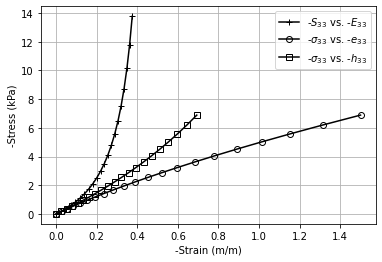

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  wipes, please run `%reset?` for details
Don't know how to reset  local, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  from, please run `%reset?` for details
Don't know how to reset  storage, please run `%reset?` for details


In [51]:
import solver_u
solver_u.main(params, printTol=False)
%reset -f # wipes local variables from storage

# Applied traction example

In [52]:
# Reinitiate problem; changed the following:
# - g_displ = 0
# - traction = 10e3 (kPa)
# - tolr = 1e-6
# - tola = 1e-6
# - numSteps = 10
import numpy as np

class Parameters:

    def __init__(self):
        self.float_dtype = np.float64 # single-precision float32 can lead to issues
        #-------------------------
        # Set material parameters.
        #-------------------------
        self.lambd = 2885
        self.mu    = 1923

        self.ns     = 0.01
        self.rhoS_0 = 1000
        self.rho_0  = self.ns*self.rhoS_0

        self.grav = 9.81
        #------------------------
        # Set constitutive model.
        #------------------------
        # self.constitutive_model = 'Saint Venant-Kirchhoff'
        self.constitutive_model = 'neo-Hookean'
        #-----------------------------------
        # Set boundary condition parameters.
        #-----------------------------------
        self.g_displ      = 0
        self.tractionLoad = 10e3
        self.t_ramp       = 1.0
        #---------------------------------
        # Set time integration parameters.
        #---------------------------------
        self.TStart   = 0.0
        self.TStop    = 1.0
        self.numSteps = 10 # set to low value for stability reasons
        self.dt       = (self.TStop - self.TStart)/self.numSteps
        self.t        = self.TStart
        self.n        = 0
        #-------------------------------
        # Set Newton-Raphson parameters.
        # - Note: loose tolerances gives
        #         better performance.
        #-------------------------------
        self.tolr = 1e-6
        self.tola = 1e-6
        self.kmax = 5
        #------------------------
        # Set element properties.
        #------------------------
        self.GaussOrder = 2
        self.numGauss   = 8
        self.numDim     = 3
        self.numElDOF   = 24

In [53]:
params = Parameters()

params.displacementProblem = False
params.tractionProblem     = True

Solving...
n = 1, t = 0.10 seconds
n = 2, t = 0.20 seconds
n = 3, t = 0.30 seconds
n = 4, t = 0.40 seconds


/home/zach/Documents/School/Boulder/Graduate/Classes/CVEN 7511/3D_Hex_Jupyter_Nonlinear_FiniteStrain/_ElementVariables.py:186: RuntimeWarning: divide by zero encountered in log
  self.Hencky = np.log(self.v)
/home/zach/Documents/School/Boulder/Graduate/Classes/CVEN 7511/3D_Hex_Jupyter_Nonlinear_FiniteStrain/_ElementVariables.py:168: RuntimeWarning: invalid value encountered in sqrt
  self.v = np.sqrt(self.b)


n = 5, t = 0.50 seconds
n = 6, t = 0.60 seconds
n = 7, t = 0.70 seconds
n = 8, t = 0.80 seconds
n = 9, t = 0.90 seconds
n = 10, t = 1.00 seconds


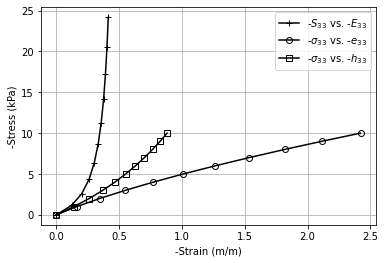

In [54]:
import solver_u
solver_u.main(params, printTol=False)
%reset -f